In [7]:
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1
import os
import sys
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import matplotlib.pyplot as plt
%matplotlib inline
from dotenv import load_dotenv
%aimport settings
import settings
import pandas as pd
import numpy as np

maxsize=3000
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 352905

import statsmodels.api as sm
from tqdm import trange
from tqdm import tqdm
import warnings
import math
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [9]:
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_extraction import settings
# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.feature_extraction import ComprehensiveFCParameters

In [10]:
sales=pd.read_csv(settings.raw_data+'/sales_train.csv')
item_cat=pd.read_csv(settings.raw_data+"/item_categories.csv")
item=pd.read_csv(settings.raw_data+"/items.csv")
sub=pd.read_csv(settings.raw_data+"/sample_submission.csv")
shops=pd.read_csv(settings.raw_data+"/shops.csv")
test=pd.read_csv(settings.raw_data+"/test.csv")

In [11]:
sales_item_price = sales[['item_id','shop_id','date_block_num','item_price']].drop_duplicates(keep = 'first')

In [12]:
pd.options.display.max_rows = 999
sales['date'] = sales.date.astype('datetime64[ns]')#pd.to_datetime(sales['date'], format='%Y-%m-%d',infer_datetime_format=True)

Month maping

In [13]:
lt_month = [i for j in range(0, 3) for i in range(1, 13)]
month = lt_month[: -2 or None] 
df_month = pd.DataFrame({'date_block_num':sales.date_block_num.unique().tolist(), 'month':month})
sales = pd.merge(sales, df_month, on = 'date_block_num', how = 'left')

In [14]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,2013-02-01,0,59,22154,999.00,1.0,1
1,2013-03-01,0,25,2552,899.00,1.0,1
2,2013-05-01,0,25,2552,899.00,-1.0,1
3,2013-06-01,0,25,2554,1709.05,1.0,1
4,2013-01-15,0,25,2555,1099.00,1.0,1


### Improve outlier detection

In [19]:
sales = sales[(sales['item_cnt_day']>0) & (sales['item_cnt_day']<sales['item_cnt_day'].max())].copy()
sales.sort_values(['date_block_num','month','shop_id','item_id'], inplace = True)

In [16]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
40085,2013-03-01,0,0,32,221.0,2.0,1
40086,2013-01-21,0,0,32,221.0,2.0,1
40087,2013-01-25,0,0,32,221.0,1.0,1
40088,2013-01-31,0,0,32,221.0,1.0,1
40089,2013-03-01,0,0,33,347.0,1.0,1


In [17]:
sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
month                      int64
dtype: object

In [20]:
sales['day']=np.where(sales['month']==sales['date'].dt.month, sales['date'].dt.day, sales['date'].dt.month)
sales['year']=sales.date.dt.year
sales['Date']=sales['year'].astype(str)+'-'+sales['month'].astype(str)+'-'+sales['day'].astype(str)
sales['Date']=sales['Date'].astype('datetime64[ns]')

In [21]:
sales.sort_values(['date_block_num','shop_id','item_id','Date'], inplace = True)
sales['Id'] = sales['Date'].astype(str) + '_' + sales['date_block_num'].astype(str) + '_' + sales['shop_id'].astype(str)+'_'+sales['item_id'].astype(str)

In [ ]:
df=sales[sales['item_category'].isin([])]

In [ ]:
df.groupby(['item_category','month']).size()

In [46]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,Id,day,year,Date
40085,2013-03-01,0,0,32,221.0,2.0,1,2013-01-03_0_0_32,3,2013,2013-01-03
40086,2013-01-21,0,0,32,221.0,2.0,1,2013-01-21_0_0_32,21,2013,2013-01-21
40087,2013-01-25,0,0,32,221.0,1.0,1,2013-01-25_0_0_32,25,2013,2013-01-25
40088,2013-01-31,0,0,32,221.0,1.0,1,2013-01-31_0_0_32,31,2013,2013-01-31
40089,2013-03-01,0,0,33,347.0,1.0,1,2013-01-03_0_0_33,3,2013,2013-01-03


https://github.com/blue-yonder/tsfresh/blob/master/notebooks/examples/03%20Feature%20Extraction%20Settings.ipynb

In [54]:
extraction_settings = ComprehensiveFCParameters()

In [55]:
fc_parameters = {"length": None, 
                  "minimum": None,
                  }

kind_to_fc_parameters = {
    "item_cnt_day": fc_parameters,
}

print(kind_to_fc_parameters)

{'item_cnt_day': {'length': None, 'minimum': None}}


In [ ]:
X = extract_features(sales[['Date','Id','item_cnt_day']],default_fc_parameters=extraction_settings, column_id='Id', column_sort='Date')

Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

In [ ]:
X.head()

In [ ]:
tsfresh.feature_extraction.feature_calculators.agg_linear_trend

Droping item_price

In [22]:
##Aggregate item count at monthly level
df_agg = sales.groupby(['shop_id','item_id','date_block_num','month'])['item_cnt_day'].sum().reset_index(drop = False).rename(columns={'item_cnt_day':'item_cnt_month'})

In [23]:
df_agg_shops = pd.merge(df_agg, shops, on = 'shop_id', how='left')
df_agg_shops = pd.merge(df_agg_shops, item, on = 'item_id', how='left')
df_agg_items = pd.merge(df_agg_shops, item_cat, on = 'item_category_id', how='left')

In [26]:
df_agg_items.sort_values(['shop_id','item_id'], inplace = True)

In [28]:
df_agg_items.head()

,shop_id,item_id,date_block_num,month,item_cnt_month,shop_name,item_name,item_category_id,item_category_name
0,0,30,1,2,31.0,"!Якутск Орджоникидзе, 56 фран",007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
1,0,31,1,2,11.0,"!Якутск Орджоникидзе, 56 фран",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray
2,0,32,0,1,6.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
3,0,32,1,2,10.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
4,0,33,0,1,3.0,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),37,Кино - Blu-Ray


### Improve Building features

In [11]:
##Build lag variables
features = ['month']
col='item_cnt_month'

In [12]:
for s in range(1, 5):
    df_agg_items["prev_shop{}_{}".format(col, s)] = df_agg_items.groupby(['date_block_num','shop_id','item_id'])[col].shift(s)
    features.append("prev_shop{}_{}".format(col, s))
df_agg_items.fillna(0, inplace = True)

In [16]:
df_agg_items[['shop_id','item_id']].drop_duplicates().shape

(424098, 2)

In [13]:
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

(214200, 3)

In [19]:
test.sort_values(['shop_id','item_id']).head()

,ID,shop_id,item_id
22987,22987,2,30
20994,20994,2,31
20995,20995,2,32
22492,22492,2,33
22491,22491,2,38


In [69]:
features

['month',
 'prev_shopitem_cnt_month_1',
 'prev_shopitem_cnt_month_2',
 'prev_shopitem_cnt_month_3',
 'prev_shopitem_cnt_month_4']

### Spliting data into train and test data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_agg_items[features], df_agg_items['item_cnt_month'], test_size=0.30, random_state=42)

In [84]:
tree = DecisionTreeRegressor(random_state = 42)
rf_p_dist={'splitter' : ['best','random'],
            'max_depth':[3,7, 10,None],
              'max_features':[3, None],
           'min_samples_leaf':[4, 7, 12],
               'min_samples_split':[8, 15, 25]
              }
clf = RandomizedSearchCV(tree, rf_p_dist, random_state=0)
search = clf.fit(X_train,y_train)
search.best_params_

{'splitter': 'random',
 'min_samples_split': 25,
 'min_samples_leaf': 12,
 'max_features': 3,
 'max_depth': 10}

In [91]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def decision_tree(train, train_labels, test, test_labels):
    rf = DecisionTreeRegressor(min_samples_leaf=12, min_samples_split=12,
                                max_depth=10, max_features=3,
                                random_state =42).fit(train, train_labels)
    pred = rf. predict(test)
    pred_train = rf. predict(train)
    
    x=np.median(train_labels)
    medianpredict1 = [x for _ in test_labels] 
    
    print('rmse baseline: ',rmse(medianpredict1, test_labels))
    print('MAE baseline: ',mean_absolute_error(test_labels,medianpredict1))
    print("rmse_test",rmse(pred, test_labels))
    print("MAE test", mean_absolute_error(test_labels, pred))
    print('rmse train', rmse(pred_train, train_labels))
    print('MAE train', mean_absolute_error(train_labels, pred_train))
    #tree_graph = tree.export_graphviz(rf, out_file=None, feature_names=features)
    return pred, pred_train, rf

In [92]:
pred, pred_train, rf = decision_tree(X_train, y_train, X_test, y_test)

rmse baseline:  8.884994065483644
MAE baseline:  1.265499473540214
rmse_test 8.791826663649136
MAE test 1.7552892895404697
rmse train 8.32334461225735
MAE train 1.763402614500924


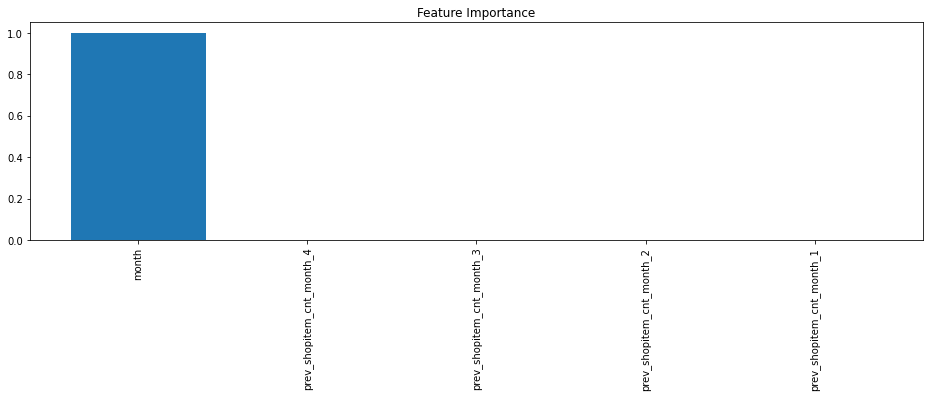

In [94]:
importances = rf.feature_importances_
# Create plot
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(16,4))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()